In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import *
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import seaborn as sbs
import numpy as np

spark = (
    SparkSession.builder.appName("MAST30034 Project 2")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.driver.memory", "2g")
    .config("spark.executer.memory", "4g")
    .getOrCreate()
)

22/09/05 02:59:38 WARN Utils: Your hostname, Luo resolves to a loopback address: 127.0.1.1; using 172.22.224.192 instead (on interface eth0)
22/09/05 02:59:38 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/09/05 02:59:39 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
path = '../data/tables/transactions_20210228_20210827_snapshot/'

In [3]:
sdf = spark.read.parquet(path)

In [4]:
sdf.select('order_datetime').distinct().count()

181

In [5]:
sdf

user_id,merchant_abn,dollar_value,order_id,order_datetime
18478,62191208634,63.255848959735246,949a63c8-29f7-4ab...,2021-08-20
2,15549624934,130.3505283105634,6a84c3cf-612a-457...,2021-08-20
18479,64403598239,120.15860593212783,b10dcc33-e53f-425...,2021-08-20
3,60956456424,136.6785200286976,0f09c5a5-784e-447...,2021-08-20
18479,94493496784,72.96316578355305,f6c78c1a-4600-4c5...,2021-08-20
3,76819856970,448.529684285612,5ace6a24-cdf0-4aa...,2021-08-20
18479,67609108741,86.4040605836911,d0e180f0-cb06-42a...,2021-08-20
3,34096466752,301.5793450525113,6fb1ff48-24bb-4f9...,2021-08-20
18482,70501974849,68.75486276223054,8505fb33-b69a-412...,2021-08-20
4,49891706470,48.89796461900801,ed11e477-b09f-4ae...,2021-08-20


In [6]:
sdf.where(F.col('dollar_value') <1500).count() / sdf.count()

0.9886686835383417

In [7]:
sdf.select('order_id').distinct().count()

3643266

In [8]:
sdf.select('merchant_abn').distinct().count()

4359

In [9]:
sdf = sdf.withColumn("is_weekend", dayofweek("order_datetime").isin([1,7]).cast("int"))\
    .withColumn("DoW", dayofweek("order_datetime").cast('int'))

In [10]:
cleaned_sdf = sdf.withColumn('dollar_value', F.round('dollar_value', 2))

In [11]:
cleaned_sdf = cleaned_sdf.where(F.col('dollar_value') > 0)

In [12]:
weekday_count = cleaned_sdf.groupBy('is_weekend').count().toPandas()

In [13]:
weekday_count

,is_weekend,count
0,1,1041277
1,0,2601852


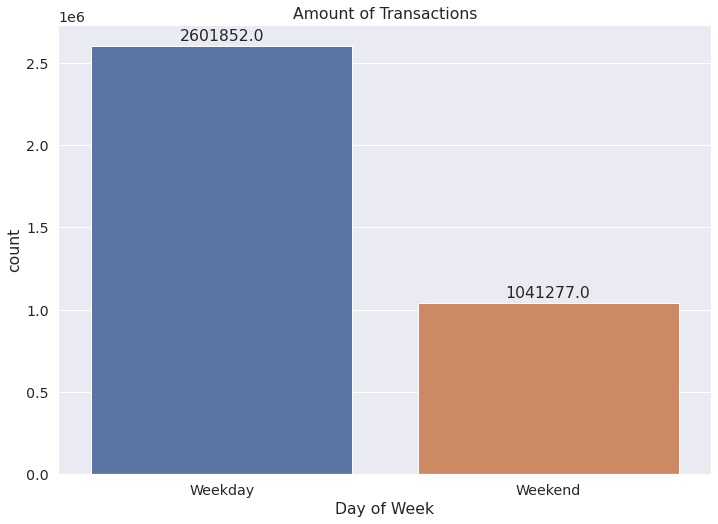

In [29]:
sbs.set(rc={'figure.figsize':(11.7,8.27)})
sbs.set_style('darkgrid')
sbs.set(font_scale=1.3)
fig = sbs.barplot(x = 'is_weekend', y = 'count', data = weekday_count)
fig.set_xticklabels(['Weekday', 'Weekend'])
fig.set_xlabel("Day of Week")
fig.set_title("Amount of Transactions")
for p in fig.patches:
    fig.annotate(format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
fig = fig.get_figure()
fig.savefig('../plots/Amount of Transactions Weekday vs Weekend.png')

In [30]:
dow_count = cleaned_sdf.groupby('DoW').count().toPandas()

In [31]:
dow_count

,DoW,count
0,1,526002
1,6,552917
2,5,539886
3,7,515275
4,2,502764
5,4,512915
6,3,493370


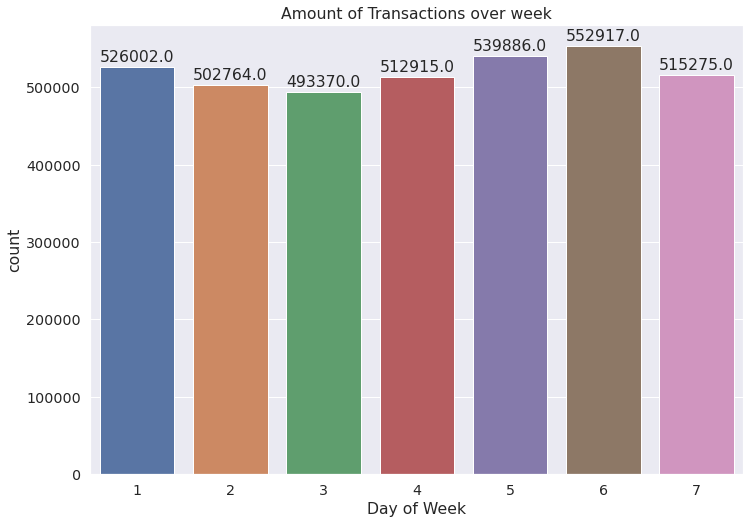

In [32]:
fig = sbs.barplot(x = 'DoW', y = 'count', data = dow_count)
fig.set_xlabel("Day of Week")
fig.set_title("Amount of Transactions over week")
for p in fig.patches:
    fig.annotate(format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
fig = fig.get_figure()
fig.savefig('../plots/Amount of Transactions over week.png')

In [33]:
day_count = cleaned_sdf.groupBy('order_datetime').count().toPandas()

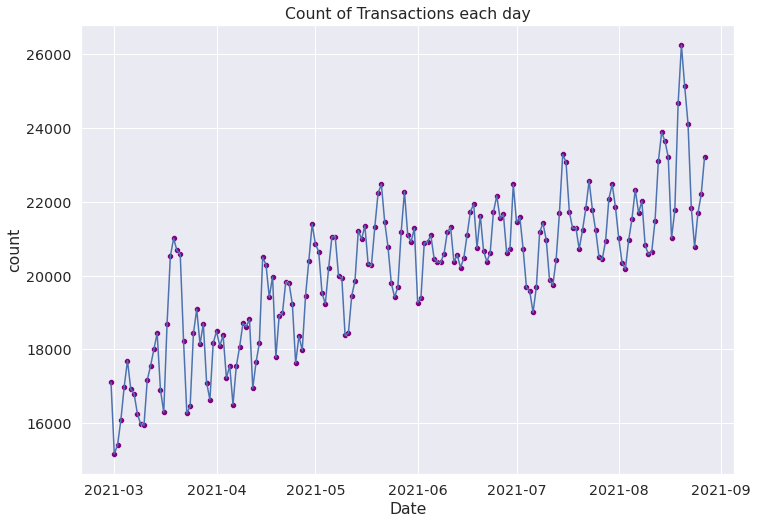

Exception in thread "serve-DataFrame" java.net.SocketTimeoutException: Accept timed out
	at java.net.PlainSocketImpl.socketAccept(Native Method)
	at java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:409)
	at java.net.ServerSocket.implAccept(ServerSocket.java:560)
	at java.net.ServerSocket.accept(ServerSocket.java:528)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:64)


In [34]:
fig = sbs.lineplot(x = 'order_datetime', y = 'count', data = day_count)
sbs.scatterplot(x = 'order_datetime', y = 'count', data = day_count, color = 'purple')
fig.set_xlabel('Date')
fig.set_title('Count of Transactions each day')
fig = fig.get_figure()
fig.savefig('../plots/Count of Transactions each day.png')

In [35]:
dow_mean = cleaned_sdf.select('dollar_value', 'DoW').groupby('DoW').mean().toPandas()

In [36]:
dow_mean

,DoW,avg(dollar_value),avg(DoW)
0,1,166.166736,1.0
1,6,164.954229,6.0
2,5,166.896346,5.0
3,7,167.734089,7.0
4,2,166.613456,2.0
5,4,166.449189,4.0
6,3,165.222969,3.0


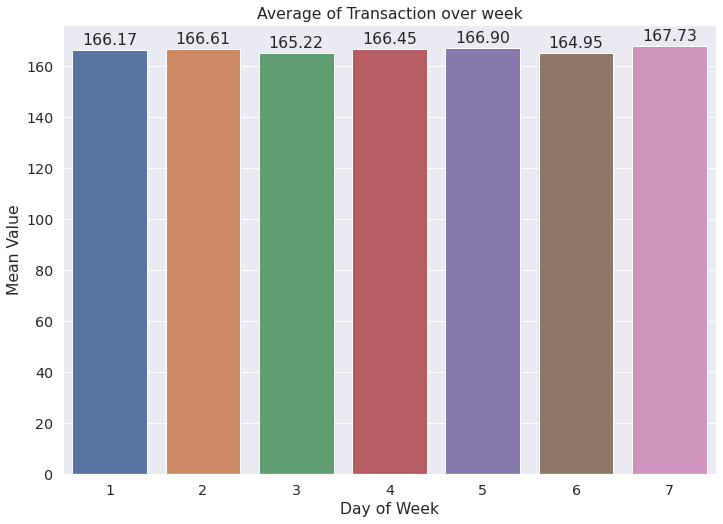

In [37]:
fig = sbs.barplot(x = 'DoW', y = 'avg(dollar_value)', data = dow_mean)
fig.set_xlabel("Day of Week")
fig.set_ylabel("Mean Value")
fig.set_title("Average of Transaction over week")
for p in fig.patches:
    fig.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
fig = fig.get_figure()
fig.savefig('../plots/Average of Transaction over week.png')

In [38]:
day_mean = cleaned_sdf.select('dollar_value', 'order_datetime').groupBy('order_datetime').mean().toPandas()

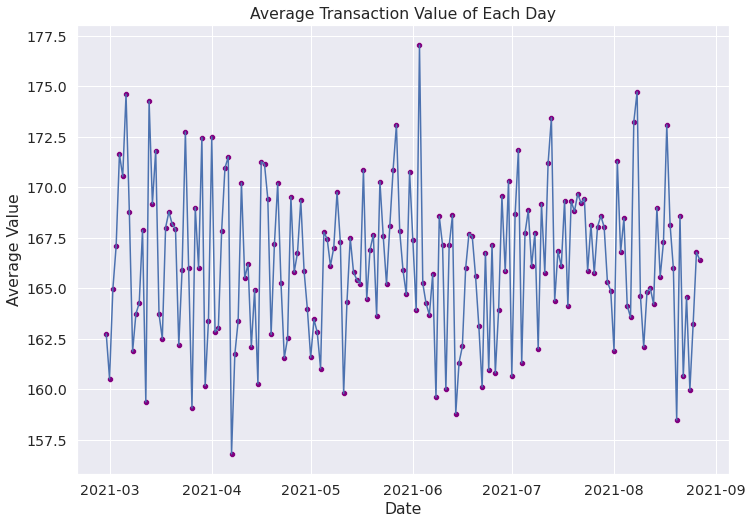

In [39]:
fig = sbs.lineplot(x = 'order_datetime', y = 'avg(dollar_value)', data = day_mean)
sbs.scatterplot(x = 'order_datetime', y = 'avg(dollar_value)', data = day_mean, color = 'purple')
fig.set_xlabel('Date')
fig.set_ylabel('Average Value')
fig.set_title("Average Transaction Value of Each Day")
fig = fig.get_figure()
fig.savefig('../plots/Average Transaction Value of Each Day.png')

In [40]:
cluster_df = cleaned_sdf \
    .groupby('merchant_abn') \
    .agg(F.expr('percentile(dollar_value, array(0.5))')[0].alias('median')) \
    .toPandas()

In [41]:
cluster_df

,merchant_abn,median
0,10023283211,185.220
1,10346855916,1022.630
2,10385163239,347.380
3,10648956813,64.320
4,10714068705,98.505
...,...,...
4354,98527912956,189.090
4355,98850646791,2091.665
4356,99009287608,142.810
4357,99420575685,4910.205


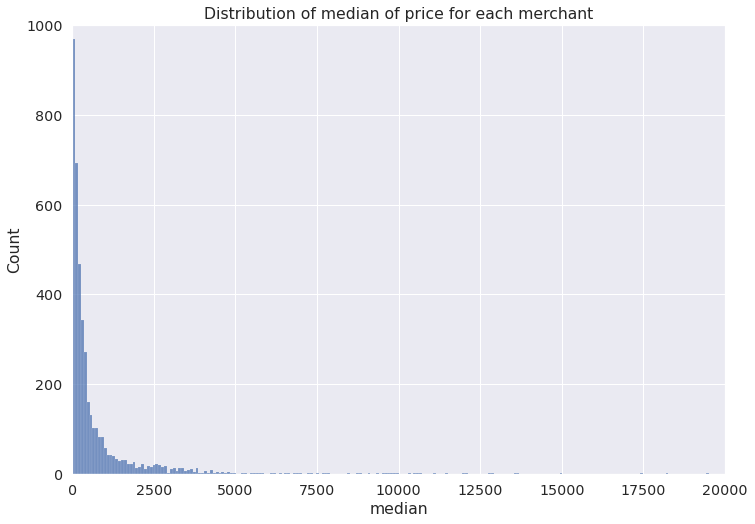

In [42]:
fig = sbs.histplot(cluster_df['median'])
fig.set_xlim(0, 20000)
fig.set_ylim(0, 1000)
fig.set_title("Distribution of median of price for each merchant")
fig = fig.get_figure()
fig.savefig('../plots/Distribution of median of price for each merchant.png')

In [43]:
cost = cleaned_sdf.select('dollar_value').toPandas()

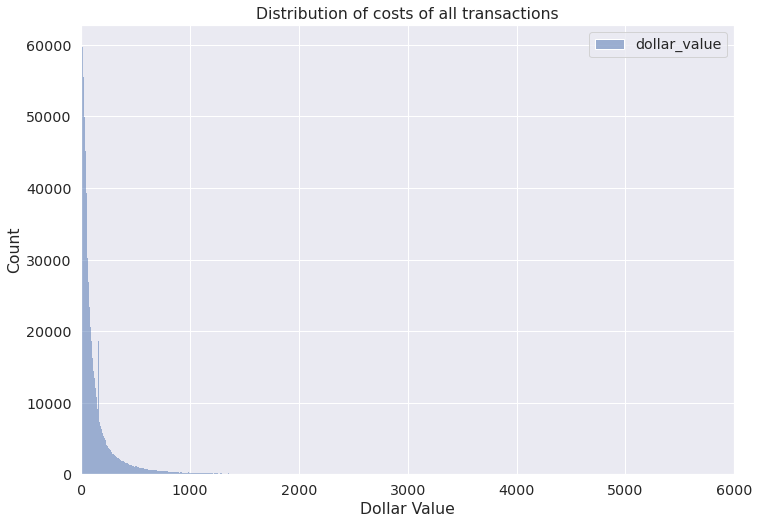

22/09/05 10:38:40 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 26238781 ms exceeds timeout 120000 ms
22/09/05 10:38:40 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.rpc.RpcTimeoutException: Futures timed out after [10000 milliseconds]. This timeout is controlled by spark.executor.heartbeatInterval
	at org.apache.spark.rpc.RpcTimeout.org$apache$spark$rpc$RpcTimeout$$createRpcTimeoutException(RpcTimeout.scala:47)
	at org.apache.spark.rpc.RpcTimeout$$anonfun$addMessageIfTimeout$1.applyOrElse(RpcTimeout.scala:62)
	at org.apache.spark.rpc.RpcTimeout$$anonfun$addMessageIfTimeout$1.applyOrElse(RpcTimeout.scala:58)
	at scala.runtime.AbstractPartialFunction.apply(AbstractPartialFunction.scala:38)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:76)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:103)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1053)
	at org.apache.spark

In [47]:
fig = sbs.histplot(cost)
fig.set_xlim(0, 6000)
fig.set_title("Distribution of costs of all transactions")
fig.set_xlabel('Dollar Value')
fig = fig.get_figure()
fig.savefig('../plots/Distribution of costs of all transactions.png')